# Data analysis du naufrage du Titanic

### Pré-processing des données

In [4]:
import numpy as np
import matplotlib as plt
import pandas as pd
import seaborn as sbs

In [31]:
data = pd.read_excel('titanic3.xls')
# On charge nos données dans une variable data

In [32]:
from sklearn.model_selection import train_test_split

In [33]:
trainset, testset = train_test_split(data, test_size=0.2, random_state = 0)
# On sépare nos données en 2 sets : un pour entraîner le modèle, et un pour le tester

In [70]:
def selection_donnees(data):
    
    res = data.drop(['name', 'sibsp', 'parch', 'ticket', 'fare', 'cabin', 'embarked', 'boat', 'body', 'home.dest'], axis=1)
    # On retire toutes les données n'ayant pas d'impact réel sur notre target (la survie ou non du passager)
    
    res = res.dropna(axis=0)
    # On retire tous les passagers dont on n'a pas toutes les infos pour éviter d'altérer la réalité

    return res

In [71]:
def encodage(data): # Encoder les données permet de les adapter au modèle
    data['sex'] = data['sex'].astype('category').cat.codes
    return data

In [75]:
def preprocessing(data):
    
    data = selection_donnees(data)
    data = encodage(data)

    X = data.drop('survived', axis = 1) # X contient les features
    y = data['survived'] # y contient les target
    
    return X,y

In [78]:
X_train, y_train = preprocessing(trainset)
X_test, y_test = preprocessing(testset)

### Modélisation

In [79]:
from sklearn.tree import DecisionTreeClassifier

In [81]:
model = DecisionTreeClassifier(random_state = 0) # Création de notre modèle

### Procédure d'évaluation

In [94]:
import matplotlib.pyplot as plt

from sklearn.metrics import f1_score, confusion_matrix, classification_report
# f1_score : proportion d'erreurs
# confusion_matrix : rapport entre faux-survivants et faux-naufragés
# classification_report : bilan de l'efficacité de notre modèle (accuracy etc)

from sklearn.model_selection import learning_curve
# learning_curve : permet de savoir si notre modèle est en over/underfitting dans le but d'adapter nos données

In [97]:
def evaluation(model):

    # Le modèle s'entraîne sur le set train
    model.fit(X_train, y_train)
    
    # il applique ce qu'il a appris lors du model.fit et prédit ainsi les résultats sur les passagers jamais vus lors de l'entraînement (X_test)
    ypred = model.predict(X_test)

    print(confusion_matrix(y_test, ypred))

    # classification_report calcule la précision, le rappel, le f1-score et le support pour chaque classe, à partir de y_test et des prédictions ypred
    print(classification_report(y_test, ypred))
    

    N, train_score, val_score = learning_curve(

        #la fonction learning_curve prend en arguments le modèle, et le train set
        model,
        X_train,
        y_train,

        # Validation croisée à 4 plis : le train set est découpé en 4 parties. 4 validations, avec chacune un pli de validation différent.
        cv = 4,

        # On utilise le score f1 comme métrique
        scoring = 'f1',

        # 10 tailles d’échantillons équidistantes (3e arg), comprises entre 10 % (1er arg) et 100 % (2e arg) de X_train
        train_sizes = np.linspace (0.1, 1, 10)
    )

    plt.figure(figsize = (6, 4))

    # L'idée en comparant le train score et le validation score est de déterminer si le modèle est en over/underfitting
    plt.plot(N, train_score.mean(axis=1), label = 'train score')
    plt.plot(N, val_score.mean(axis=1), label = 'validation score')
    
    plt.legend()

[[112  13]
 [ 29  51]]
              precision    recall  f1-score   support

           0       0.79      0.90      0.84       125
           1       0.80      0.64      0.71        80

    accuracy                           0.80       205
   macro avg       0.80      0.77      0.78       205
weighted avg       0.80      0.80      0.79       205



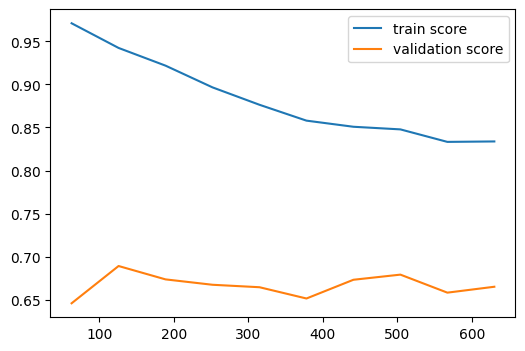

In [98]:
evaluation(model)

On remarque que notre modèle est en overfitting : son train score est relativement élevé (bien qu'il baisse avec plus de données) alors que son validation score reste relativement faible et ne croît pas.
Le modèle apprend correctement les règles spécifiques aux données d'entraînement, mais ne généralise pas. Il est donc inefficace sur des données qu'il n'a jamais vues dans le train set.
Il va donc falloir optimiser notre modèle, pour améliorer sa capacité de généralisation.

### Optimisation